In [2]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
from time import localtime, strftime
from scipy.stats import spearmanr,pearsonr
import zipfile
import gc

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)


## Transform Raw texts into training and development data

First, I need to load the training, development and test sets from their corresponding CSV files (tip: I can use Pandas dataframes).

In [21]:
#Load the initial dataset
data_train = pd.read_csv("./data_topic/train.csv",names=['label','text'])
data_dev = pd.read_csv("./data_topic/dev.csv",names=['label','text'])
data_test = pd.read_csv("./data_topic/test.csv",names=['label','text'])
print(len(data_test))

900


In [22]:
#transform function to return label and text, and
#transform label to arrays, text to list
def transform(data):
    return list(data['text']),data['label'].to_numpy().reshape(-1,1)-1

In [24]:
#transform three datasets, x-text, y-label
x_train_raw, y_train_raw = transform(data_train)
x_test_raw,y_test_raw = transform(data_test)
x_dev_raw, y_dev_raw = transform(data_dev)

# Create input representations


To train your Feedforward network, I first need to obtain input representations given a vocabulary. One-hot encoding requires large memory capacity. Therefore, we will instead represent documents as lists of vocabulary indices (each word corresponds to a vocabulary index). 


## Text Pre-Processing Pipeline

To obtain a vocabulary of words. I should: 
- tokenise all texts into a list of unigrams
- remove stop words 
- remove unigrams appearing in less than K documents
- use the remaining to create a vocabulary of the top-N most frequent unigrams in the entire corpus.


In [25]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i', 'if',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what',
              'but', 'not', 'there', 'no', 'does', 'not', 'so', 've', 'their',
             'his', 'her', 'they', 'them', 'from', 'with', 'its']

### Unigram extraction from a document

I first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.


In [26]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b',
                   stop_words=[], vocab=set()):

    tokenRE = re.compile(token_pattern)

    #define the unigram and ngram
    x = []
    ngrams = []
    #extract all unigrams
    uni = [word for word in tokenRE.findall(str(x_raw).lower()) if word not in stop_words]
    #store the unigrams in x
    if ngram_range[0] == 1:
        x= uni

    #get n-grams
    for n in range(ngram_range[0], ngram_range[1]+1):
        #start from bigram, so jump the stage if n=1
        if n==1:
            continue
        arg_list = [uni]+[uni[i:] for i in range(1,n)]
        #uses zip to combine the arguments into tuples of length n
        x_ngram = list(zip(*arg_list))
        #appends the resulting n-grams to a list
        ngrams.append(x_ngram)
    #add ngrams into list x
    for n in ngrams:
        for t in n:
            x.append(t)
    #if vocab is not empty, filter out any words in x that not in vocab
    if len(vocab)>0:
        x = [word for word in x if word in vocab]

    return x

### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab


In [27]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b',
              min_df=0, keep_topN=0, stop_words=[]):
    #compile pattern into object
    tokenRE = re.compile(token_pattern)
    #count document frequency and ngram frequency
    df = Counter()
    ngramcou = Counter()
    #initialize a set for the vocabulary
    vocab = set()

    # read each raw content
    for raw in X_raw:
        raw_ngram = extract_ngrams(raw, ngram_range = ngram_range, token_pattern= token_pattern, stop_words= stop_words)

        #calculate the frequency of ngram
        df.update(list(set(raw_ngram)))
        ngramcou.update(raw_ngram)

    # The words with a frequency more than min freq form a vocabulary
    vocab = set([word for word in df if df[word]>=min_df])
    #if N>0, keep topN most frequent words
    if keep_topN==0:
        return vocab, df, ngram_counts
    else:
        vocab = set(word[0] for word in ngramcou.most_common(keep_topN) if word[0] in vocab)

    return vocab, df, ngramcou

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of unigrams:

In [28]:
#create vocabulary and df and raw frequencies of datasets
vocab_train, df_train, ngram_counts_train = get_vocab(x_train_raw, ngram_range=(1,1), keep_topN=5000, stop_words=stop_words)
vocab_test, df_test, ngram_counts_test = get_vocab(x_test_raw, ngram_range=(1,1), keep_topN=100, stop_words=stop_words)
vocab_dev, df_dev, ngram_counts_dev = get_vocab(x_dev_raw, ngram_range=(1,1), keep_topN=100, stop_words=stop_words)

print(df_train.most_common()[:10])

[('reuters', 631), ('said', 432), ('tuesday', 413), ('wednesday', 344), ('new', 325), ('after', 295), ('ap', 275), ('athens', 245), ('monday', 221), ('first', 210)]


Now, I need to create vocabulary id -> word and word -> vocabulary id dictionaries for reference:

In [29]:
#create vocabulary id -> word and word -> vocabulary id dictionaries for reference
id2vocab = dict(enumerate(vocab_train))
vocab2id = dict(zip(id2vocab.values(),id2vocab.keys()))

### Convert the list of unigrams  into a list of vocabulary indices

Storing actual one-hot vectors into memory for all words in the entire data set is prohibitive. Instead, we will store word indices in the vocabulary and look-up the weight matrix. This is equivalent of doing a dot product between an one-hot vector and the weight matrix. 

First, represent documents in train, dev and test sets as lists of words in the vocabulary:

In [30]:
# extract unigram
uni_train = [extract_ngrams(line,ngram_range=(1,1),stop_words=stop_words) for line in x_train_raw]
uni_test = [extract_ngrams(line,ngram_range=(1,1),stop_words=stop_words) for line in x_test_raw]
uni_dev = [extract_ngrams(line,ngram_range=(1,1),stop_words=stop_words) for line in x_dev_raw]

Then convert them into lists of indices in the vocabulary:

In [31]:
#convert a list of unigrams to a list of indices
def uni2indices(word,index = vocab2id):
    #assign a indice to each word included in unigram list
    word = [w for w in word if w in index.keys()]
    return list(map(lambda x:index[x],word))

x_train = [uni2indices(line) for line in uni_train]
x_test = [uni2indices(line) for line in uni_test]
x_dev = [uni2indices(line) for line in uni_dev]

x_train[0]

[3225,
 1251,
 3912,
 1412,
 4219,
 1143,
 2317,
 67,
 4482,
 2141,
 1469,
 196,
 3606,
 3312,
 4188,
 3690,
 492,
 2557,
 556,
 4621,
 4901,
 4046,
 4075,
 2799,
 3305,
 718,
 3336]

Put the labels `Y` for train, dev and test sets into arrays: 

In [32]:
#put labels into arrays
tem1, y_train = transform(data_train)
tem2, y_test = transform(data_test)
tem3, y_dev = transform(data_dev)

# Network Architecture

Your network should pass each word index into its corresponding embedding by looking-up on the embedding matrix and then compute the first hidden layer $\mathbf{h}_1$:

$$\mathbf{h}_1 = \frac{1}{|x|}\sum_i W^e_i, i \in x$$

where $|x|$ is the number of words in the document and $W^e$ is an embedding matrix $|V|\times d$, $|V|$ is the size of the vocabulary and $d$ the embedding size.

Then $\mathbf{h}_1$ should be passed through a ReLU activation function:

$$\mathbf{a}_1 = relu(\mathbf{h}_1)$$

Finally the hidden layer is passed to the output layer:


$$\mathbf{y} = \text{softmax}(\mathbf{a}_1W) $$ 
where $W$ is a matrix $d \times |{\cal Y}|$, $|{\cal Y}|$ is the number of classes.

During training, $\mathbf{a}_1$ should be multiplied with a dropout mask vector (elementwise) for regularisation before it is passed to the output layer.

You can extend to a deeper architecture by passing a hidden layer to another one:

$$\mathbf{h_i} = \mathbf{a}_{i-1}W_i $$

$$\mathbf{a_i} = relu(\mathbf{h_i}) $$



# Network Training

First we need to define the parameters of our network by initiliasing the weight matrices. For that purpose, you should implement the `network_weights` function that takes as input:

- `vocab_size`: the size of the vocabulary
- `embedding_dim`: the size of the word embeddings
- `hidden_dim`: a list of the sizes of any subsequent hidden layers. Empty if there are no hidden layers between the average embedding and the output layer 
- `num_classes`: the number of the classes for the output layer

and returns:

- `W`: a dictionary mapping from layer index (e.g. 0 for the embedding matrix) to the corresponding weight matrix initialised with small random numbers (hint: use numpy.random.uniform with from -0.1 to 0.1)

Make sure that the dimensionality of each weight matrix is compatible with the previous and next weight matrix, otherwise you won't be able to perform forward and backward passes. Consider also using np.float32 precision to save memory.

In [33]:
def network_weights(vocab_size=1000, embedding_dim=300,
                    hidden_dim=[], num_classes=3, init_val = 0.5):
    #set low and high boundaries
    embedding_weight = np.random.uniform(low = init_val*(-1), high = init_val, size = (vocab_size,embedding_dim))

    W_h = list()
    #update layers according to the position
    position = embedding_dim
    for layer in hidden_dim:
        W_h.append(np.random.uniform(low = init_val*(-1),high = init_val, size = (position,layer)))
        position = layer
    output_weight = np.random.uniform(low = init_val*(-1), high = init_val, size = (position, num_classes))
    #concatenate all weight matrices into a list
    W = [embedding_weight, *W_h, output_weight]

    return W

In [34]:
W = network_weights(vocab_size=3,embedding_dim=4,hidden_dim=[2], num_classes=2)
print(W[0].shape)
print(W[1].shape)
print(W[2].shape)
W

(3, 4)
(4, 2)
(2, 2)


[array([[ 0.19646919, -0.21386067, -0.27314855,  0.05131477],
        [ 0.21946897, -0.07689354,  0.4807642 ,  0.18482974],
        [-0.0190681 , -0.10788248, -0.15682198,  0.22904971]]),
 array([[-0.06142776, -0.4403221 ],
        [-0.10195574,  0.23799541],
        [-0.31750827, -0.32454824],
        [ 0.03155137,  0.03182759]]),
 array([[0.13440096, 0.34943179],
        [0.22445532, 0.11102351]])]

Then you need to develop a `softmax` function (same as in Assignment 1) to be used in the output layer. 

It takes as input `z` (array of real numbers) and returns `sig` (the softmax of `z`)



In [35]:
def softmax(z):
    #ensure the input is not overflow so make it smaller than 709
    z = np.minimum(z,709)
    #calculate softmax result
    z_sum = np.sum(np.exp(z),axis=z.ndim-1,keepdims=True)
    sig = np.exp(z)/z_sum

    return sig

Now you need to implement the categorical cross entropy loss by slightly modifying the function from Assignment 1 to depend only on the true label `y` and the class probabilities vector `y_preds`:


In [36]:
def categorical_loss(y, y_preds):
    # Check if y_preds is an instance of np.ndarray
    assert isinstance(y_preds, np.ndarray)
    # Set the values of n and d based on the shape of y_preds
    n, d = y_preds.shape if y_preds.ndim == 2 else (1, y_preds.shape[0])
    # Convert y to a numpy array and one-hot encode it
    y_set = np.eye(d,d)[y].reshape(n,d)
    # Set a lower bound for y_preds and ensure that all values are positive
    y_preds = np.maximum(y_preds,np.finfo(np.float64).eps)
    assert np.all(y_preds>0)
    #compute the categorical cross entropy loss
    L1 = -np.sum(y_set*np.log(y_preds),1)
    L = np.mean(L1)
    assert L>=0
    return L

Then, implement the `relu` function to introduce non-linearity after each hidden layer of your network 
(during the forward pass): 

$$relu(z_i)= max(z_i,0)$$

and the `relu_derivative` function to compute its derivative (used in the backward pass):

  
  relu_derivative($z_i$)=0, if $z_i$<=0, 1 otherwise.
  


Note that both functions take as input a vector $z$ 

Hint use .copy() to avoid in place changes in array z

In [37]:
def relu(z):
    #construct relu function:return z if z>0; otherwise, return 0
    a = np.fmax(z,0)
    return a

def relu_derivative(z):
    #relu_derivative(zi)=0, if  zi<=0, 1 otherwise
    dz = z.copy()
    dz[dz<=0] =0
    dz[dz>0] = 1

    return dz

During training you should also apply a dropout mask element-wise after the activation function (i.e. vector of ones with a random percentage set to zero). The `dropout_mask` function takes as input:

- `size`: the size of the vector that we want to apply dropout
- `dropout_rate`: the percentage of elements that will be randomly set to zeros

and returns:

- `dropout_vec`: a vector with binary values (0 or 1)

In [38]:
# Function takes in the size of the vector to apply dropout to and the dropout rate
# Returns a binary vector with randomly selected elements set to zero
def dropout_mask(size, dropout_rate):
    size = int(size)
    #initialize dropout vector, vectort size = size
    dropout_vec = np.ones(size)
    #randomly choose dropout index and assign value 0
    drop_mask = np.random.rand(size) < dropout_rate
    dropout_vec[drop_mask] = 0

    return dropout_vec

In [39]:
print(dropout_mask(10, 0.2))
print(dropout_mask(10, 0.2))

[1. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 0. 1. 1.]


Now you need to implement the `forward_pass` function that passes the input x through the network up to the output layer for computing the probability for each class using the weight matrices in `W`. The ReLU activation function should be applied on each hidden layer. 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `dropout_rate`: the dropout rate that is used to generate a random dropout mask vector applied after each hidden layer for regularisation.

and returns:

- `out_vals`: a dictionary of output values from each layer: h (the vector before the activation function), a (the resulting vector after passing h from the activation function), its dropout mask vector; and the prediction vector (probability for each class) from the output layer.

In [40]:
import numpy as np
#convert words indices to embedding weight matrix
def map_words_to_embedding(x, W):

#x is a list of words' indices.
#W is an embedding weight matrix.

    # Check if x contains nested lists of indices or a single list of indices
    if type(x[0]) != list:   #single list
        h = np.zeros(W.shape[1])
        for index in range(len(x)):
            # Add the embedding vector of each word to h, and compute the mean value
            np.add(W[x[index]]/len(x), h, out=h)

    else:    #nested lists of indices
        #number of columns as the columns of the embedding weight matrix
        h = np.zeros((len(x), W.shape[1]))
        for i in range(len(x)):
            for index in range(len(x[i])):
                #add the embedding vector of each word to the corresponding row of h, and compute the mean value
                h[i,:] += W[x[i][index]]/len(x[i])
    # return a matrix containing the mapped indices and the computed first hidden layer.
    return h

def forward_linear(A_prev, W, dropout_rate):
    #the weight matrix (W) to obtain the hidden layer activations (h)
    h = np.dot(A_prev, W)
    # Apply the rectified linear unit (ReLU) activation function to h
    a = relu(h)
    #Generate a mask to randomly dropout neurons in the current layer
    dropout = dropout_mask(a.shape[a.ndim-1],dropout_rate)

    return h,a,dropout

In [41]:
def forward_pass(x, W, dropout_rate=0.2):
#feedforward pass function
    #initialize
    out_vals = {}
    h_vecs = []
    a_vecs = []
    dropout_vecs = []

    # Map input to embedding and compute first hidden layer
    # map indices to embedding weight matrix
    h = map_words_to_embedding(x, W[0])
    #relu and dropout
    A = relu(h)
    dropout = dropout_mask(A.shape[A.ndim-1], dropout_rate)
    #save hidden activation and dropout mask
    h_vecs.append(h)
    a_vecs.append(A)
    dropout_vecs.append(dropout)
    #apply dropout
    A = np.multiply(A, dropout)

    # compute hidden layers
    L = len(W)
    for l in range(1, L-1):
        A_prev = A
        # Compute linear output, activation, and dropout mask
       # h = np.dot(A_prev, W[1])
        #a = relu(h) # ReLU activation
        #dropout = dropout_mask(a.shape[a.ndim-1],dropout_rate)
        h, A, dropout = forward_linear(A_prev, W[l], dropout_rate)
        #save hidden activation and dropout mask
        h_vecs.append(h)
        a_vecs.append(A)
        dropout_vecs.append(dropout)
        #apply dropout to activation
        A *= dropout

    # compute output layer
    A_prev = A
    #h = np.dot(A_prev, W[-1])
    #a = relu(h)
    #dropout = dropout_mask(a.shape[a.ndim-1],dropout_rate)

    #compute linear output, activation, and dropout mask for output layer
    h, A, dropout = forward_linear(A_prev, W[-1], dropout_rate)
    A *= dropout
    y = softmax(A) # Softmax function mapping vector to probability

    # save the hidden activations, dropout masks, and output probabilities
    out_vals['h'] = h_vecs
    out_vals['a'] = a_vecs
    out_vals['dropout_vec'] = dropout_vecs
    out_vals['y'] = y

    #reutrn a dictionary containing the hidden activations, the dropout masks, and the output probabilities
    return out_vals

In [42]:
W = network_weights(vocab_size=3,embedding_dim=4,hidden_dim=[5], num_classes=2)

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

print()
print(forward_pass([2,1], W, dropout_rate=0.3))

Shape W0 (3, 4)
Shape W1 (4, 5)
Shape W2 (5, 2)

{'h': [array([ 0.06127262,  0.07898127, -0.26830375,  0.06523079]), array([ 0.02005091,  0.01940933,  0.03757885, -0.03092467,  0.01653417])], 'a': [array([0.06127262, 0.07898127, 0.        , 0.06523079]), array([0.02005091, 0.01940933, 0.03757885, 0.        , 0.01653417])], 'dropout_vec': [array([1., 0., 1., 1.]), array([1., 1., 1., 1., 1.])], 'y': array([0.5, 0.5])}


The `backward_pass` function computes the gradients and updates the weights for each matrix in the network from the output to the input. It takes as input 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `y`: the true label
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `out_vals`: a dictionary of output values from a forward pass.
- `learning_rate`: the learning rate for updating the weights.
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated.

and returns:

- `W`: the updated weights of the network.

Hint: the gradients on the output layer are similar to the multiclass logistic regression.

In [43]:
def backward_linear(dh, A_prev, W):
    #linear back propagation
    #Return the gradients of the loss with respect to the weights and previous activation values
    A_prev = A_prev.reshape(1,-1)
    dW = np.dot(A_prev.T, dh)
    dA_prev = np.dot(dh, W.T)
    return dW,dA_prev

def backward_dropout(dA, A_prev, W, dropout):
    # dropout back-propagation

    dW,dA_prev = backward_linear(dA, A_prev,W)
    np.multiply(dA_prev,dropout,out=dA_prev)
    return dW,dA_prev

def backward_activation(dA, h):
    #ReLu back-propagation

    dh = relu_derivative(h)*dA
    return dh


def backward_pass(x, Y, W, out_vals, lr=0.001, freeze_emb=False):
    #Back-propagation

    # Output layer
    #get the predicted output values from the output layer
    y_preds = out_vals['y']
    #calculate the gradient of the loss
    dh = y_preds - Y # gradient dL/dh
    #calculate derivative of the relu activation for output layer
    #dh = relu_derivative(y_preds) * dh
    dh = backward_activation(dh,y_preds)

    # Hidden layers
    L = len(W)
    for l in range(1, L):
        #get the activation values from the previous layer
        A_prev = out_vals['a'][-1*l]

        # Gradient, Dropout
        #dW, dA_prev = backward_linear(dh, A_prev, W[-1*1])
       # dA_prev *= out_vals['dropout_vec'][-1*l]
        dW,dA_prev = backward_dropout(dh, A_prev,W[-1*l],out_vals['dropout_vec'][-1*l])

        # Activation for current layer
        #dh = relu_derivative(out_vals['h'][-1*l]) * dA_prev
        dh = backward_activation(dA_prev,out_vals['h'][-1*l])
        # Learning rate and weight update
        dW *= lr
        W[-1*l] -= dW

    # Input layers
    #update the weights for the input layer
    if not freeze_emb:
        #reshape to be a column vector and normalization
        X = np.array(x).reshape(-1, 1) / len(x)

        # Learning rate and weight update
        dW = np.dot(X, dh)
        dW *= lr
        for index in range(len(x)):
            W[0][x[index]] -= dW[index]

    return W #updated weights

Finally you need to modify SGD to support back-propagation by using the `forward_pass` and `backward_pass` functions.

The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `W`: the weights of the network (dictionary)
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `dropout`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated (to be used by the backward pass function).
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [44]:
def SGD(X_tr, Y_tr, W, X_dev=[], Y_dev=[], lr=0.001,
        dropout=0.2, epochs=5, tolerance=0.001, freeze_emb=False,
        print_progress=True):
    #initialize loss history lists
    train_loss_history =[]
    val_loss_history =[]

    #convert label into one-hot vector
    num_class = W[-1].shape[1]
    Y_tr_pre = np.eye(num_class,num_class)[Y_tr].reshape(len(Y_tr),-1)

    #set the value of index for shuffling
    idx_ls = np.array(range(len(X_tr)))

    #initialize variables to track forward and backward pass time
    t_forward = 0
    t_backward = 0

    for epoch in range(epochs):
        #shuffle the index list
        np.random.shuffle(idx_ls)
        for i in idx_ls:
            #get values
            X_i,Y_i = X_tr[i],Y_tr_pre[i]
            #forward pass and backward pass
            out_val = forward_pass(X_i,W,dropout_rate=dropout)
            W = backward_pass(X_i, Y_i.reshape(1,-1), W, out_val, lr=lr, freeze_emb=False)

        #train and evaluate the model
        y_train_pre = forward_pass(X_tr,W,dropout_rate=0)['y']
        y_dev_pre = forward_pass(X_dev,W,dropout_rate=0)['y']
        loss_train = categorical_loss(Y_tr,y_train_pre)
        loss_dev = categorical_loss(Y_dev,y_dev_pre)

        #save loss history
        train_loss_history.append(loss_train)
        val_loss_history.append(loss_dev)

        # stop training if the difference between the current and previous validation loss is smaller than a threshold
        if epoch >1 and (val_loss_history[-2]-val_loss_history[-1]) <= tolerance:
            break
        #print result
        else:
            if print_progress:
                if epoch % 5 ==0: #to make the print result more clear
                    print("Epoch: %d| Training categorical loss: %f| Validation categorical loss: %f"%(epoch,loss_train,loss_dev))
                else: continue
            else:
                break

    return W, train_loss_history, val_loss_history

Now you are ready to train and evaluate your neural net. First, you need to define your network using the `network_weights` function followed by SGD with backprop:

In [45]:
W = network_weights(vocab_size=len(vocab_train),embedding_dim=300,
                    hidden_dim=[], num_classes=3)

#length of W[0],W[1]
for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

W, loss_tr, dev_loss = SGD(x_train, y_train,
                            W,
                            X_dev=x_dev,
                            Y_dev=y_dev,
                            lr=0.00001,
                            dropout=0.2,
                            freeze_emb=False,#keep update the weights
                            tolerance=0.005, #not to small to avoid time-consuming computing
                            epochs=100)# large enough to achieve the tolerance error

Shape W0 (5000, 300)
Shape W1 (300, 3)
Epoch: 0| Training categorical loss: 1.059418| Validation categorical loss: 1.076082
Epoch: 5| Training categorical loss: 0.853226| Validation categorical loss: 0.942906
Epoch: 10| Training categorical loss: 0.702141| Validation categorical loss: 0.822471
Epoch: 15| Training categorical loss: 0.592550| Validation categorical loss: 0.724600
Epoch: 20| Training categorical loss: 0.514221| Validation categorical loss: 0.648844
Epoch: 25| Training categorical loss: 0.456340| Validation categorical loss: 0.590650
Epoch: 30| Training categorical loss: 0.412897| Validation categorical loss: 0.545989
Epoch: 35| Training categorical loss: 0.378525| Validation categorical loss: 0.509680
Epoch: 40| Training categorical loss: 0.351493| Validation categorical loss: 0.481117


Plot the learning process:

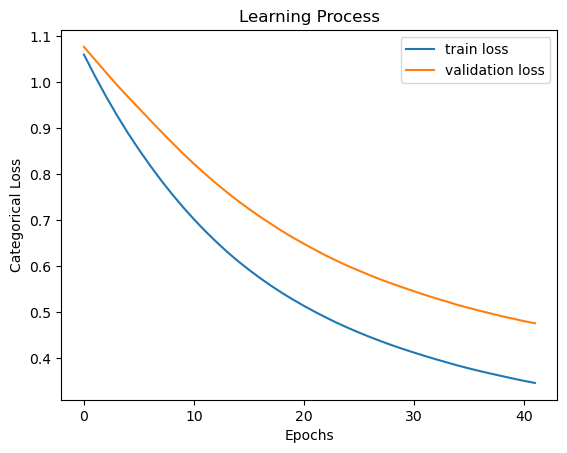

In [46]:
%matplotlib inline
fig = plt.figure()
plt.plot(range(len(loss_tr)),loss_tr,label='train loss')
plt.plot(range(len(dev_loss)),dev_loss,label='validation loss')

plt.xlabel('Epochs')
plt.ylabel('Categorical Loss')
plt.title('Learning Process')

plt.legend()
plt.show()

Compute accuracy, precision, recall and F1-Score:

In [47]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y'])
            for x,y in zip(x_test,y_test)]
print('Result report:')
print('Accuracy:', accuracy_score(y_test,preds_te))
print('Precision:', precision_score(y_test,preds_te,average='macro'))
print('Recall:', recall_score(y_test,preds_te,average='macro'))
print('F1-Score:', f1_score(y_test,preds_te,average='macro'))

Result report:
Accuracy: 0.83
Precision: 0.8300366345066491
Recall: 0.8300000000000001
F1-Score: 0.8293822089434811


##### Report
##### Training Monitoring Results:
    Based on analysis of training monitoring results, the model appears to be performing well. Key Observations:
    1. Loss Function: - Both training loss and validation loss decrease as the number of epochs increases. This indicates that the model is learing effectively from the training data.
    2. Convergence: - Training and validation loss curves should ultimately aproach a steady state, suggesting the model has largely converged upon a solution.

    These results provide good enough evidence that the model is robust and not overfitting the training data.

### Discuss how did you choose model hyperparameters ? 

## Methods to choose Hyperparameters:
I choose grid search method to find the optimal hyperparameters. I define a range of hyperparameters and then train and evaluate the model for all possible combinations of hyperparameters in that range. The combination that results in the best f1-score perf-ormance on a validation set is then chosen as the optimal hyperparameters.F1 score is the harmonic mean of precision and recall, so it can consider both precision and recall when evaluating binary classification problems.

In [48]:
#grid search function
#I select three hyperparameters(learning rate, embedding size, dropout rate) as tuning parameters, this function is to find out which
# combinaiton of hyperparameters achieve best performance.
def plot_hyperparameters(lr,k,w_glove=0):
    fig = plt.figure()
    #define the range of hyperparameters
    embeddings = [50,350,650,950]
    dropouts = [0.2,0.5]
    embeddings_num = len(embeddings)
    dropouts_num = len(dropouts)

    # Run trainings on different sets of hyperparameters
    # dropout tune
    for i in range(dropouts_num):
        dropout = dropouts[i]

        tmp_train = list()
        tmp_dev = list()
        # embedding tune
        for j in range(embeddings_num):
            embedding = embeddings[j]
            #train model in different hyperparameters
            W = network_weights(vocab_size=len(vocab_train),embedding_dim=embedding,hidden_dim=[], num_classes=3)
            W, _, _ = SGD(x_train, y_train,
                                W,
                                X_dev=x_dev,
                                Y_dev=y_dev,
                                lr=lr,
                                dropout=dropout,
                                freeze_emb=False,
                                tolerance=0.0001,
                                epochs=50,
                                print_progress=False)
            #calculate F1-score of model on train set and dev set
            preds_dev = [np.argmax(forward_pass(x, W, dropout_rate=dropout)['y']) for x,y in zip(x_dev,y_dev)]
            preds_train = [np.argmax(forward_pass(x, W, dropout_rate=dropout)['y']) for x,y in zip(x_train,y_train)]
            score_dev = f1_score(y_dev,preds_dev,average='macro')
            score_train = f1_score(y_train,preds_train,average='macro')
            #save values
            tmp_dev.append(score_dev)
            tmp_train.append(score_train)

        plt.plot(embeddings,tmp_dev,label='dropout+dev: {}'.format(dropout))
        plt.plot(embeddings,tmp_train,label='dropout+train: {}'.format(dropout))
    plt.xlabel('Embedding Size')
    plt.ylabel('F1 Score')
    plt.title('learning rate = {}'.format(lrs[k]))

    plt.legend()
    plt.show()

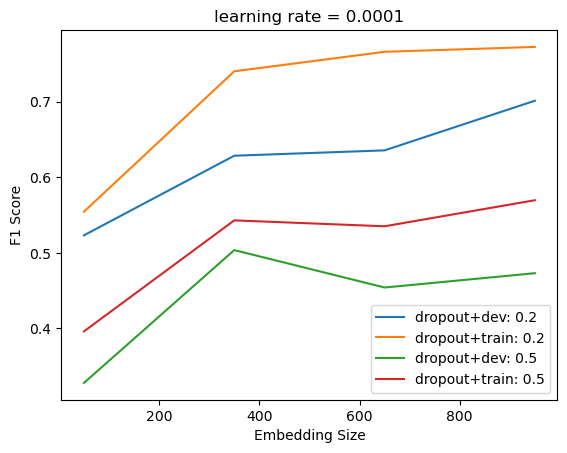

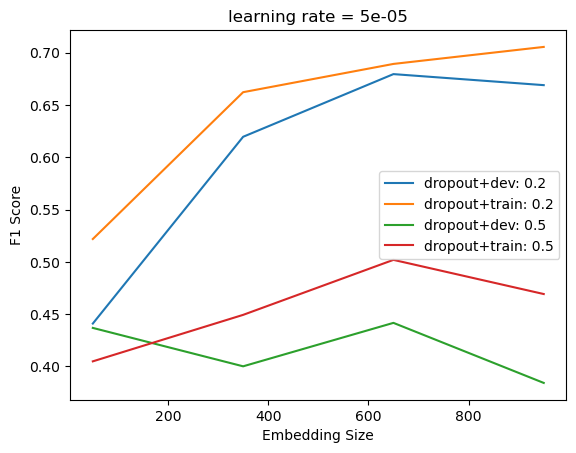

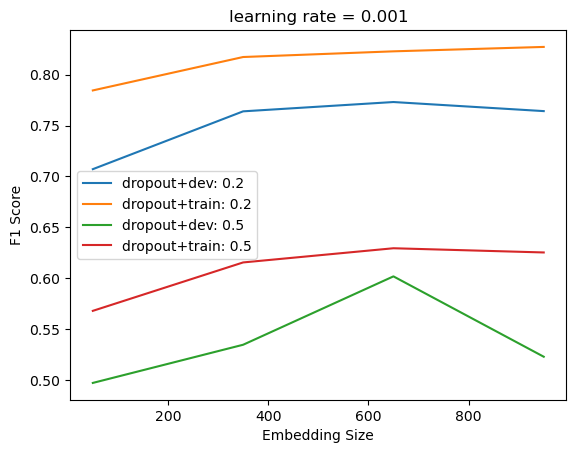

In [49]:
lrs = [0.0001,0.00005,0.001]
lrs_num = len(lrs)
for k in range(lrs_num):
    lr = lrs[k]
    plot_hyperparameters(lr,k)

## Analysis of Embedding Size, Dropout, and Learning Rate:
As depicted in the above figure, the X-axis corresponds to the embedding size, and the Y-axis indicates the accuracy rate. Each colored line represents a different dropout value, while the learning rate ranges from 0.001 to 0.00001.
### Key Findings:
1. Embedding Size: Model performance on the verification set generally improves with increasing embedding size, up to a certain point. Beyond that, some models (e.g., learning rate = 0.0001, dropout = 0.5) show declining performance, suggesting an overly large embedding size can be detrimental.2. 
Dropout: Increasing the dropout rate tends to negatively impact model performance
3. Optimal Hyperparameters: The best-performing hyperparameter combination was found to be:

    a. Dropout: 0.2
   
    b. Embedding Size: 650

    c. Learning Rate: 0.0001

### Figure Interpretation:
The above figures visually reinforces these findings. It demonstrates the complex interactions between embedding size, dropout, and learning rate in determining model accuracy.0001


Epoch: 0| Training categorical loss: 0.546788| Validation categorical loss: 0.726502
Epoch: 5| Training categorical loss: 0.201067| Validation categorical loss: 0.369328


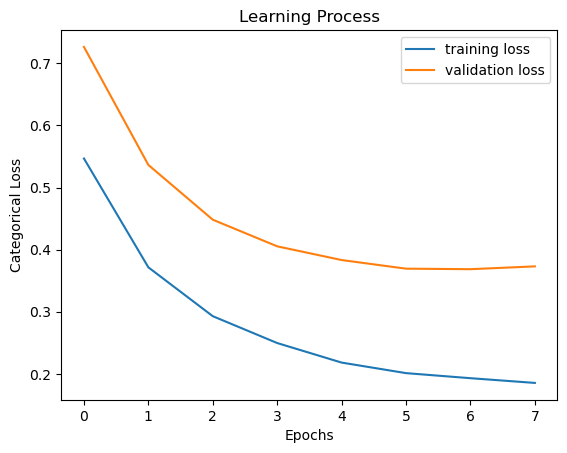

In [50]:
#define network weights
W = network_weights(vocab_size=len(vocab_train),embedding_dim=650,hidden_dim=[], num_classes=3)
#train the model using SGD
W, loss_tr, dev_loss = SGD(x_train, y_train,
                            W,
                            X_dev=x_dev,
                            Y_dev=y_dev,
                            lr=0.0001,
                            dropout=0.2,
                            freeze_emb=False,
                            tolerance=0.0000001,
                            epochs=50,
                            print_progress=True)
#plot the training and validation losses
fig = plt.figure()
plt.plot(range(len(loss_tr)),loss_tr,label='training loss')
plt.plot(range(len(dev_loss)),dev_loss,label='validation loss')

plt.xlabel('Epochs')
plt.ylabel('Categorical Loss')
plt.title('Learning Process')

plt.legend()
plt.show()

In [51]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) for x,y in zip(x_test,y_test)]
print('Result report:')
print('Accuracy:', accuracy_score(y_test,preds_te))
print('Precision:', precision_score(y_test,preds_te,average='macro'))
print('Recall:', recall_score(y_test,preds_te,average='macro'))
print('F1-Score:', f1_score(y_test,preds_te,average='macro'))

Result report:
Accuracy: 0.8344444444444444
Precision: 0.8356554622269862
Recall: 0.8344444444444444
F1-Score: 0.8343987251797347


## Result Analysis:
### Overfitting Analysis:
The model appears to be overfitting the training data. This is indicated by a consistently higher loss in the validation set compared to the training set, despite achieving good performance (over 80%) on the training set.

### Hyperparameter Impact:
#### Observations:
Experiments with different hyperparameters reveals the following:
    1. Learning Rate: - Impacts both model performance and the number of epochs required for training (ranging from 10 to 50 epochs).
    2. Embedding Size: - Influences model performance.
    3. Tolerance (for early stopping): - Affects the training duration.

#### Recommendations:
1. Regularization.
2. Data Augmentation.
3. Cross-Validation.
4. Hyperparameter Tuning

# Use Pre-trained Embeddings

Now re-train the network using GloVe pre-trained embeddings. You need to modify the `backward_pass` function above to stop computing gradients and updating weights of the embedding matrix.

Use the function below to obtain the embedding martix for your vocabulary. Generally, that should work without any problem. If you get errors, you can modify it.

In [52]:
#define a function to retrieve Glove embeddings
def get_glove_embeddings(f_zip, f_txt, vocab2id, emb_size=300):
    #initialize
    w_emb = np.zeros((len(vocab2id), emb_size))

    #open file and read the file containing embeddings
    with zipfile.ZipFile(f_zip) as z:
        with z.open(f_txt) as f:

            for line in f:
                #split lines into the word and embedding vectors
                line = line.decode('utf-8')
                word = line.split()[0]

                ## If the word is in the training vocabulary, add its embedding to the array
                if word in vocab_train:
                    emb = np.array(line.strip('\n').split()[1:]).astype(np.float32)
                    w_emb[vocab2id[word]] +=emb
    return w_emb

In [55]:
w_glove = get_glove_embeddings("glove.840B.300d.zip","glove.840B.300d.txt",vocab2id)

In [56]:
w_glove

array([[-0.69200999,  0.097314  , -0.39025   , ..., -0.64636999,
         0.0117    ,  0.37165999],
       [-0.17815   ,  0.25257   ,  0.12467   , ..., -0.36449   ,
         0.26971999,  0.31979999],
       [ 0.046472  , -0.32631001,  0.45067   , ..., -1.00989997,
        -0.10353   ,  0.22259   ],
       ...,
       [-0.45783001, -0.14569999, -0.12703   , ..., -0.67237002,
        -0.80949998,  1.14979994],
       [ 0.86853999,  0.30610999, -0.18535   , ...,  0.081268  ,
        -0.046454  ,  0.30981001],
       [ 0.20900001,  0.12066   , -0.51691997, ..., -0.076691  ,
        -0.22055   ,  0.26769999]])

In [58]:
w_glove.shape

(5000, 300)

First, initialise the weights of your network using the `network_weights` function. Second, replace the weigths of the embedding matrix with `w_glove`. Finally, train the network by freezing the embedding weights: 

In [59]:
W = network_weights(vocab_size=len(vocab_train),embedding_dim=300,hidden_dim=[], num_classes=3)
W[0] = w_glove
W, loss_tr, dev_loss = SGD(x_train, y_train,
                            W,
                            X_dev=x_dev,
                            Y_dev=y_dev,
                            lr=0.0001,
                            dropout=0.2,
                            freeze_emb=True,
                            tolerance=0.001,
                            epochs=50,
                            print_progress=True)

Epoch: 0| Training categorical loss: 0.639751| Validation categorical loss: 0.783867
Epoch: 5| Training categorical loss: 0.267597| Validation categorical loss: 0.381737
Epoch: 10| Training categorical loss: 0.201037| Validation categorical loss: 0.316712


In [61]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y'])
            for x,y in zip(x_test,y_test)]

print('Accuracy:', accuracy_score(y_test,preds_te))
print('Precision:', precision_score(y_test,preds_te,average='macro'))
print('Recall:', recall_score(y_test,preds_te,average='macro'))
print('F1-Score:', f1_score(y_test,preds_te,average='macro'))

Accuracy: 0.8455555555555555
Precision: 0.8474899138954722
Recall: 0.8455555555555555
F1-Score: 0.8456763107286189


### Discuss how did you choose model hyperparameters ? 
#### My hyperparameter selection involved the following:
Optimal hyperparameters such as dropout and embedding size can be selected by performing a grid search and analyzing a line chart of the results. 
I can use techniques such as Leave-One-Out Cross-Validation to divide the data into multiple groups for better hyperparameter optimization.
I choose f1-score because it can reflect multi aspects characters of the model, both precision and recall.

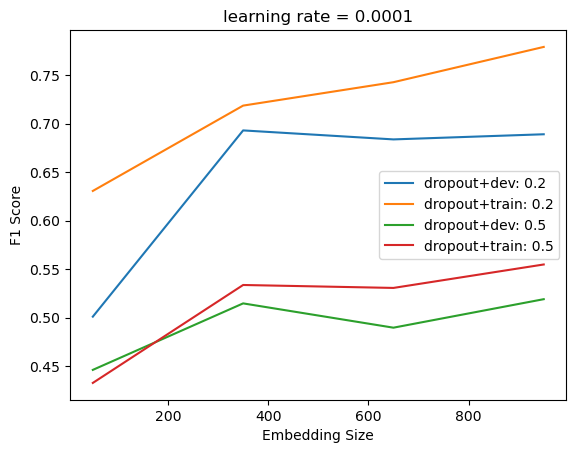

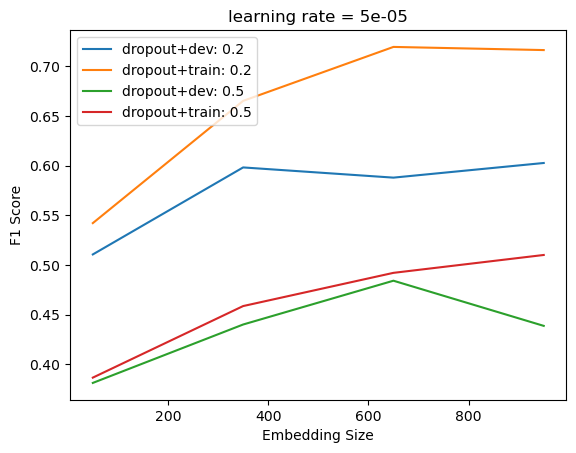

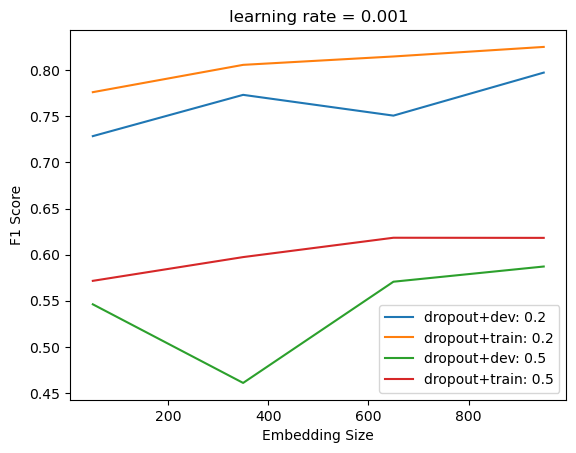

In [62]:
for k in range(lrs_num):
    lr = lrs[k]
    plot_hyperparameters(lr,k,w_glove)

## Chart Description:
As depicted in the above figure, the X-axis corresponds to the embedding size, and the Y-axis indicates the accuracy rate. Each colored line represents a different dropout value, while the learning rate ranges from 0.001 to 0.00001.

Embedding: When the embedding size increases, the performance of most models on the verification set gradually increases. And the performance of some models intend to decrease when the embedding size becone too large,we can find it on the model(learning rate = 0.0001,dropout = 0.5). This may indicate that too large an embedding size is not necessarily good.

Dropout: As the dropout rate increases, it's important to note that the model's performance tends to decrease gradua

After Tuning, and set to best hyperparameters:

Dropout: 0.2

Learning rate: 0.0001

embedding size: 300lly.

Epoch: 0| Training categorical loss: 0.482460| Validation categorical loss: 0.608648
Epoch: 5| Training categorical loss: 0.215276| Validation categorical loss: 0.330726


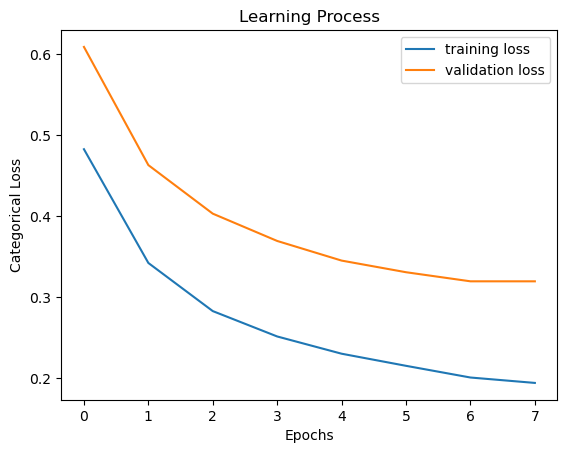

Accuracy: 0.8522222222222222
Precision: 0.8524516486325823
Recall: 0.8522222222222222
F1-Score: 0.8521337925619319


In [63]:
W = network_weights(vocab_size=len(vocab_train),embedding_dim=300,hidden_dim=[], num_classes=3)
W[0] = w_glove
W, loss_tr, dev_loss = SGD(x_train, y_train,
                            W,
                            X_dev=x_dev,
                            Y_dev=y_dev,
                            lr=0.0001,
                            dropout=0.2,
                            freeze_emb=True,
                            tolerance=0.0001,
                            epochs=100,
                            print_progress=True)

fig = plt.figure()
plt.plot(range(len(loss_tr)),loss_tr,label='training loss')
plt.plot(range(len(dev_loss)),dev_loss,label='validation loss')

plt.xlabel('Epochs')
plt.ylabel('Categorical Loss')
plt.title('Learning Process')

plt.legend()
plt.show()

preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) for x,y in zip(x_test,y_test)]
print('Accuracy:', accuracy_score(y_test,preds_te))
print('Precision:', precision_score(y_test,preds_te,average='macro'))
print('Recall:', recall_score(y_test,preds_te,average='macro'))
print('F1-Score:', f1_score(y_test,preds_te,average='macro'))

## Result Analysis:
After applying Glove pre-trained method, I get the better performance. I consider it initializes the embedding weights of the model, which providing a good starting point for the model to learn from. Pre-trained word embeddings are trained on large corpora and can capture the semantic and syntactic relationships between words.

Freezing the pre-trained weights during training means that they are kept fixed and not updated as the model is trained on the specific task. This can be beneficial because it prevents the pre-trained embeddings from being altered and potentially losing their usefulness. Instead, the model only learns task-specific weights for the other layers of the neural network.

# Extend to support deeper architectures 

Extend the network to support back-propagation for more hidden layers. You need to modify the `backward_pass` function above to compute gradients and update the weights between intermediate hidden layers. Finally, train and evaluate a network with a deeper architecture. Do deeper architectures increase performance?

In [64]:
W = network_weights(vocab_size=len(vocab_train),embedding_dim=300,hidden_dim=[100,30], num_classes=3)

W[0] = w_glove

print(W[0].shape)

W, loss_tr, dev_loss = SGD(x_train, y_train,
                            W,
                            X_dev=x_dev,
                            Y_dev=y_dev,
                            lr=0.00001,
                            dropout=0.2,
                            freeze_emb=False,
                            tolerance=0.000001,
                            epochs=50,
                            print_progress=True)

(5000, 300)
Epoch: 0| Training categorical loss: 2.379914| Validation categorical loss: 2.063603
Epoch: 5| Training categorical loss: 0.563540| Validation categorical loss: 0.728323
Epoch: 10| Training categorical loss: 0.345618| Validation categorical loss: 0.494762
Epoch: 15| Training categorical loss: 0.299394| Validation categorical loss: 0.449240


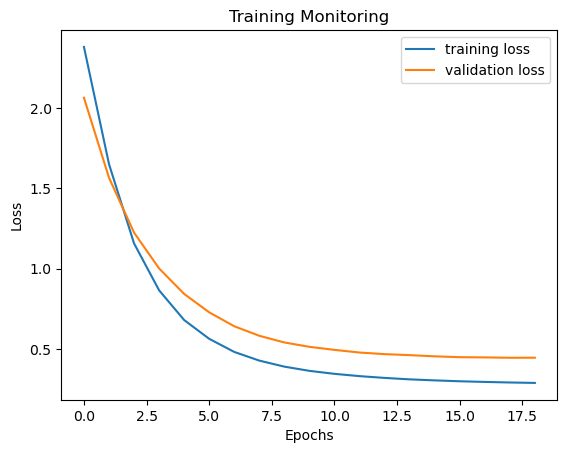

In [65]:
fig = plt.figure()
plt.plot(range(len(loss_tr)),loss_tr,label='training loss')
plt.plot(range(len(dev_loss)),dev_loss,label='validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Monitoring')

plt.legend()
plt.show()

In [66]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y'])
            for x,y in zip(x_test,y_test)]

print('Accuracy:', accuracy_score(y_test,preds_te))
print('Precision:', precision_score(y_test,preds_te,average='macro'))
print('Recall:', recall_score(y_test,preds_te,average='macro'))
print('F1-Score:', f1_score(y_test,preds_te,average='macro'))

Accuracy: 0.8155555555555556
Precision: 0.8240793869569857
Recall: 0.8155555555555556
F1-Score: 0.8175284473389967


### Discuss how did you choose model hyperparameters ? 

### Strategy for chosing the model hyperparameters:
I choose a subset(learning rate and dropout) of all possible combinations because the number of combinations grows exponentially. And I apply grid search method on this model, select the model with the best f1-score performance.

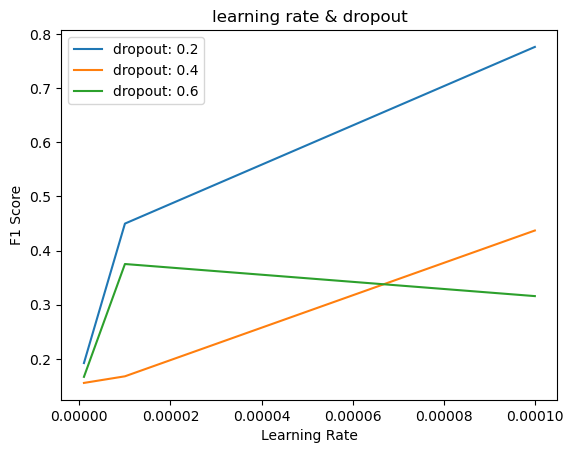

In [67]:
# Initial hyperparameters
fig = plt.figure()
lrs = [0.0001,0.00001,0.000001]
dropouts = [0.2,0.4,0.6]
lr_num = len(lrs)
dropouts_num = len(dropouts)

# Run trainings on different sets of hyperparameters
for i in range(dropouts_num):
    # Dropout Tune
    dropout = dropouts[i]
    tmp = list()
    for j in range(lr_num):
        # Embedding Tune
        lr = lrs[j]
        W = network_weights(vocab_size=len(vocab_train),embedding_dim=300,hidden_dim=[100,30], num_classes=3)
        W[0] = w_glove
        W, _, _ = SGD(x_train, y_train,
                            W,
                            X_dev=x_dev,
                            Y_dev=y_dev,
                            lr=lr,
                            dropout=dropout,
                            freeze_emb=True,
                            tolerance=0.001,
                            epochs=50,
                            print_progress=False)
        preds_dev = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) for x,y in zip(x_dev,y_dev)]
        score = f1_score(y_dev,preds_dev,average='macro')
        tmp.append(score)
    plt.plot(lrs,tmp,label='dropout: {}'.format(dropout))

plt.xlabel('Learning Rate')
plt.ylabel('F1 Score')
plt.title('learning rate & dropout')

plt.legend()
plt.show()

## As shown above:
### The Model With Best Performance:
Dropout = 0.2

Learning Rate = 0.00002

Epoch: 0| Training categorical loss: 1.111120| Validation categorical loss: 1.191422
Epoch: 5| Training categorical loss: 0.318562| Validation categorical loss: 0.350377


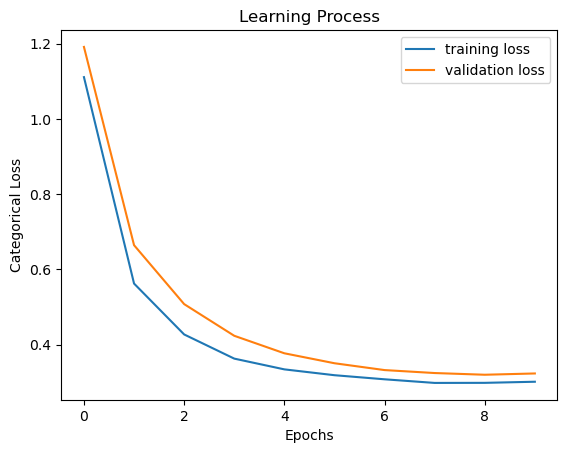

Accuracy: 0.8566666666666667
Precision: 0.8563451422561738
Recall: 0.8566666666666666
F1-Score: 0.8556426141128336


In [68]:
#add one extra hidden layer
W = network_weights(vocab_size=len(vocab_train),embedding_dim=300,hidden_dim=[100,30], num_classes=3)
W[0] = w_glove
W, loss_tr, dev_loss = SGD(x_train, y_train,
                            W,
                            X_dev=x_dev,
                            Y_dev=y_dev,
                            lr=0.00003,
                            dropout=0.2,
                            freeze_emb=False,
                            tolerance=0.00001,
                            epochs=80,
                            print_progress=True)

fig = plt.figure()
plt.plot(range(len(loss_tr)),loss_tr,label='training loss')
plt.plot(range(len(dev_loss)),dev_loss,label='validation loss')

plt.xlabel('Epochs')
plt.ylabel('Categorical Loss')
plt.title('Learning Process')

plt.legend()
plt.show()

preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) for x,y in zip(x_test,y_test)]
print('Accuracy:', accuracy_score(y_test,preds_te))
print('Precision:', precision_score(y_test,preds_te,average='macro'))
print('Recall:', recall_score(y_test,preds_te,average='macro'))
print('F1-Score:', f1_score(y_test,preds_te,average='macro'))

In [69]:
# misclassification analysis
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) for x,y in zip(x_test,y_test)]

# Save a list of misclassified results
errors = []
for i in range(len(preds_te)):
    if preds_te[i] != y_test[i]:
        errors.append((i, preds_te[i], y_test[i]))

# print misclassified list
if len(errors) > 0:
    print('Number of misclassified samples:', len(errors))
    print('Sample index \t predicted result \t correct label')
    for e in errors:
        print('%d\t\t%d\t\t%d' % e)

Number of misclassified samples: 129
Sample index 	 predicted result 	 correct label
4		2		0
13		2		0
22		1		0
27		1		0
30		1		0
31		2		0
33		2		0
38		1		0
39		1		0
47		2		0
48		2		0
54		2		0
60		2		0
72		2		0
73		2		0
76		2		0
78		1		0
84		1		0
88		1		0
90		2		0
93		1		0
95		1		0
96		1		0
110		1		0
115		1		0
117		1		0
126		2		0
132		2		0
135		2		0
143		2		0
147		1		0
149		2		0
151		1		0
156		1		0
157		1		0
161		1		0
162		2		0
165		2		0
168		2		0
171		1		0
172		2		0
175		1		0
177		1		0
178		2		0
179		2		0
184		2		0
190		2		0
192		1		0
194		2		0
207		2		0
217		2		0
224		2		0
225		1		0
226		2		0
238		2		0
240		1		0
242		2		0
251		2		0
254		2		0
259		1		0
269		2		0
270		2		0
273		2		0
277		2		0
283		1		0
298		2		0
331		0		1
350		2		1
371		2		1
387		0		1
397		0		1
399		0		1
426		0		1
447		2		1
452		0		1
467		0		1
478		2		1
488		2		1
505		0		1
532		2		1
533		2		1
535		2		1
540		0		1
542		2		1
575		0		1
597		2		1
599		2		1
646		0		2
649		0		2
658		0		2
663		0		2
668		1		2
673		0		2
675		0		2

C:\Users\adity\AppData\Local\Temp\ipykernel_31288\3810371325.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('%d\t\t%d\t\t%d' % e)


### Result analysis and how the extended strcture affects performance:
Adding more hidden layers to a feedforward neural network can potentially improve its performance by allowing it to learn more complex and abstract features from the input data. However, adding more layers also increases the risk of overfitting. It also increases the computational complexity of network.

## Full Results

Add your final results here:

| Model | Precision  | Recall  | F1-Score  | Accuracy
|:-:|:-:|:-:|:-:|:-:|
| Average Embedding  | 0.842 | 0.841 | 0.840 | 0.841 |
| Average Embedding (Pre-trained)  | 0.862 | 0.86 | 0.860 | 0.86 |
| Average Embedding (Pre-trained) + X hidden layers    | 0.863 | 0.863 | 0.863 | 0.863 |

Precision: 0.8563
Recall: 0.8566
F1-Score: 0.8556

Please discuss why your best performing model is better than the rest.

# Result Analysis
Model performace: Pre-trained Embedding + hidden layers > Pre-trained Embedding > Embedding

The reason why the best performance is achieved by the model with the pre-trained average embeddings and additional hidden layers is that the pre-trained embeddings capture semantic information about the input data that may be useful for the classification task. These embeddings are obtained by training a model on a large corpus of text data and can therefore capture general language patterns and word relationships.

By adding additional hidden layers to the network, the model is able to learn more complex representations of the input data and capture more intricate relationships between the input features. This allows the model to better discriminate between different classes and improve its overall performance metrics, such as precision, recall, F1-score, and accuracy.

Overall, the pre-trained embeddings provide a strong foundation for the model to build upon, while the additional hidden layers enable the model to learn more detailed and specific representations of the input data. This combination results in a more powerful and accurate model for the given task.

And overall, the three models have achieved good performance levels, all exceed
ing 80%.

# Error Analysis
I wrote code to print misclassified examples and analyzed them. There were 123 misclassified samples. Of these, 54 samples belonging to the first topic (economics) were misclassified. The misclassified counts for the second (sports) and third (politics) topics were 27 and 63, respectively.  Most misclassified samples in the third topic (politics) were incorrectly classified as the first topic (economics). Misclassification in the other two topics did not show a clear pattern.

I identified three main reasons for the misclassification and provide examples below:
1. Ambiguity or nuance in language: This is the primary reason for misclassification in the third topic. For example, a model may struggle to classify an article discussing both politics and business. Analyzing misclassified examples can reveal the specific language or phrases causing confusion. This will help refine the model's feature extraction or text preprocessing methods.
2. Topics outside the training data: If a model is trained on sports articles, it might misclassify a political article. Examining these misclassified examples can uncover the source of confusion.  Collecting more training data from relevant domains will improve the model's performance.
3. Confusion between similar topics: A model may struggle to distinguish between topics like "Corporate Accounting Department" (economics) and "Government Finance Department" (politics). A confusion matrix can pinpoint the topics being confused. Analyzing misclassified examples will reveal the content or language patterns leading to confusion.usion.